In [184]:
from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras import losses, optimizers, metrics, callbacks
import matplotlib.pyplot as plt
import numpy as np


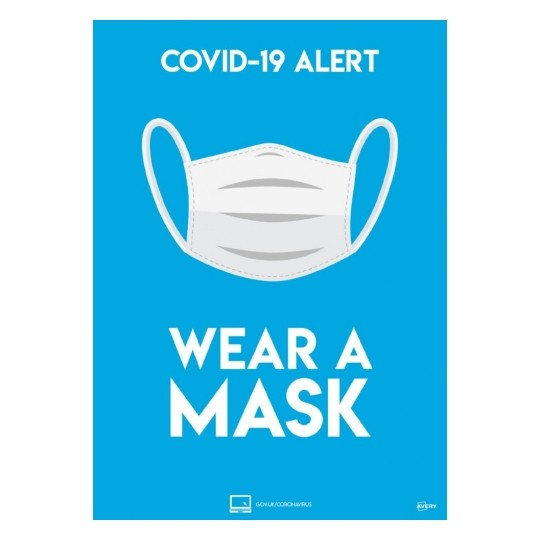

**DESCRIPTION OF THE CODE**: Face mask dataset has 3 folders which are validation, train and test. In them, there are people photos, some of them with mask and some of them without mask. This is a good dataset to work on classification

In [185]:
#download data from kaggle and unzip it
files.upload() # import the json file provided by kaggle
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

!unzip -q /content/face-mask-12k-images-dataset.zip

Saving kaggle.json to kaggle (4).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
face-mask-12k-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [186]:
#define pathes
train_d = '/content/Face Mask Dataset/Train'
test_d = '/content/Face Mask Dataset/Test'
val_d = '/content/Face Mask Dataset/Validation'


In [187]:
# create train/test/validation datasets tf object from data in the folder
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_d,color_mode='rgb',batch_size=64,image_size = (64, 64),shuffle = True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(train_d,color_mode='rgb',batch_size=64,image_size = (64, 64),shuffle = True)

val_data = tf.keras.preprocessing.image_dataset_from_directory(train_d,color_mode='rgb',batch_size=64,image_size = (64, 64),shuffle = True)

Found 10000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.


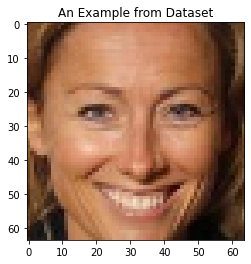

In [188]:
#plot an example image from dataset
x = next(iter(train_data))[0][0]
x = tf.cast(x, 'float32') / 255.0
plt.imshow(x)
plt.title("An Example from Dataset")
plt.show()

In [189]:
train_data #check the shape

<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

In [190]:
#define a cast function for pre-processing
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [191]:
def augment(image, label):
    image = tf.image.random_brightness(image, 0.1) #create randim brightness
    image = tf.image.random_flip_left_right(image) #creare random flipping to left/right
    return image, label

In [192]:
#Add pre-processing/augmentation on train,val,test datasets

train_data = train_data.map(preprocess).map(augment).cache().prefetch(tf.data.experimental.AUTOTUNE)

val_data = val_data.map(preprocess).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_data= test_data.map(preprocess).cache().prefetch(tf.data.experimental.AUTOTUNE)

**DESCRIPTION OF THE CODE**: 
Here there is a model for classification , it is mainly composed by convolutional layers, max pooling to reduce size and at the end dense layer to get a binary output.
After building the model , next step is train the model with train&validation sets and view graphs of loss and accuracy values.

In [194]:
#Build Model
#there are two classes, with mask and without mask
# In the model, there are 4 Conv Layer with MaxPooling
# There are two FC layers  with Dropout 
#For output softmax is used as activation funtion

num_classes = 2 
input_size = (64,64,3)
input = Input(shape=input_size) #start with it

model = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_size)(input)
model = MaxPooling2D((2, 2),padding='same')(model)

model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)

model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)

model = Conv2D(128, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)

model = Flatten()(model)

model = Dense(1024)(model)
model = Dropout(0.2)(model)

model = Dense(64)(model)
model = Dropout(0.2)(model)

output= Dense(num_classes, activation='sigmoid')(model)
model = Model(inputs=[input], outputs=[output])

In [195]:
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 8, 8, 64)          0  

In [196]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer=optimizers.Adam(),
              metrics=[metrics.SparseCategoricalAccuracy()])

In [197]:
# There are two callbacks, one to stop training if an early stopping condition is met, the other to stop training if some NaN values are encountered in the loss.
callbacks = [callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, restore_best_weights=True),
             callbacks.TerminateOnNaN()]

In [198]:
#Train the model
history= model.fit(train_data, epochs=10, validation_data=val_data, callbacks=callbacks)

Epoch 1/10
157/157 [==============================] - 92s 576ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.0967 - val_sparse_categorical_accuracy: 0.9642
Epoch 2/10
157/157 [==============================] - 67s 426ms/step - loss: 0.0836 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.0345 - val_sparse_categorical_accuracy: 0.9893
Epoch 3/10
157/157 [==============================] - 66s 424ms/step - loss: 0.0559 - sparse_categorical_accuracy: 0.9799 - val_loss: 0.0283 - val_sparse_categorical_accuracy: 0.9902
Epoch 4/10
157/157 [==============================] - 67s 428ms/step - loss: 0.0287 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.0225 - val_sparse_categorical_accuracy: 0.9916
Epoch 5/10
157/157 [==============================] - 67s 427ms/step - loss: 0.0210 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0288 - val_sparse_categorical_accuracy: 0.9900
Epoch 6/10
157/157 [==============================] - 66s 422ms/step - loss: 0.0231 -

In [199]:
history.history.keys() #check values names

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

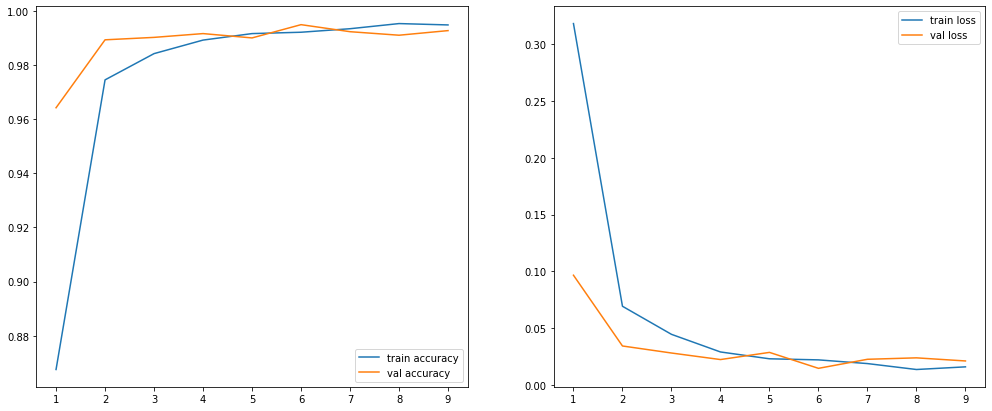

In [200]:
#plot graph to show train and loss details
epochs = np.arange(1, len(history.history['sparse_categorical_accuracy'])+1,1)
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.plot(epochs,  history.history['sparse_categorical_accuracy'] ,label='train accuracy')
plt.plot(epochs,  history.history['val_sparse_categorical_accuracy'] ,label='val accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,  history.history['loss'] ,label='train loss')
plt.plot(epochs,  history.history['val_loss'] ,label='val loss')
plt.legend()

In [201]:
#Test the model
model.evaluate(test_data)

157/157 [==============================] - 27s 165ms/step - loss: 0.0148 - sparse_categorical_accuracy: 0.9949


[0.014829881489276886, 0.9948999881744385]

**DESCRIPTION OF THE CODE**: The chosen method is the iterpretability. It uses the library tf-explain and the particular method is the visualization of the activation maps. In this examples all the channels in output coming from the third convolutional layers, of size (16,16,64) will be shown for a particular input image. In this way it is possible to understand how each filter is acting on the image and where it is focusing on.

In [202]:
!pip install tf-explain

     |████████████████████████████████| 51kB 2.6MB/s 


In [218]:
from tf_explain.core import  ExtractActivations

def generate_activation(img_idx):
    target_layers = ['conv2d_83']
    grad_x, grad_y = next(iter(test_data))

    explainer = ExtractActivations()
    map = explainer.explain((grad_x[img_idx:img_idx+1], None), model, 
                            target_layers)

    return grad_x[img_idx], map

Examples of activation maps for the third convolutional layer that has 64 filters with size 16x16.

In this example a person with a mask is shown. One convolutional layer has a filter which channel values are high in absolute value.

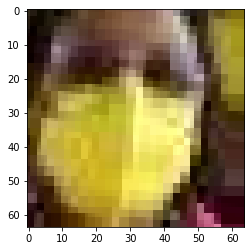

In [221]:
img, activation = generate_activation(9)
plt.imshow(img)

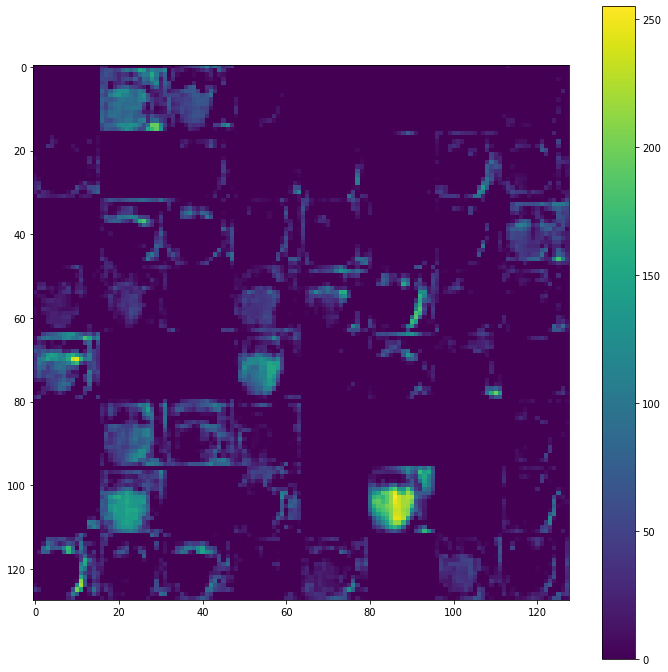

In [222]:
plt.figure(figsize=(12,12))
plt.imshow(activation)
plt.colorbar()

Another person with mask and there is another filter reacting to mask area.

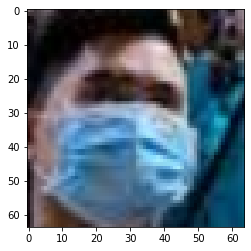

In [232]:
img1, activation1 = generate_activation(43)
plt.imshow(img1)

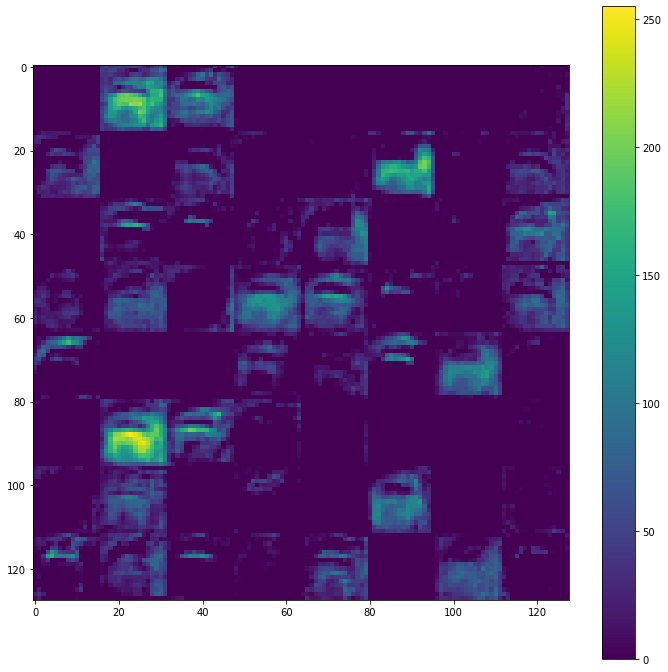

In [233]:
plt.figure(figsize=(12,12))
plt.imshow(activation1)
plt.colorbar()

In this example there is a person without mask. The filters that before were reacting well on the mask now are reacting poorely.

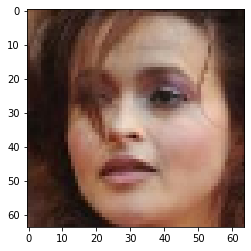

In [234]:
img2, activation2 = generate_activation(49)
plt.imshow(img2)

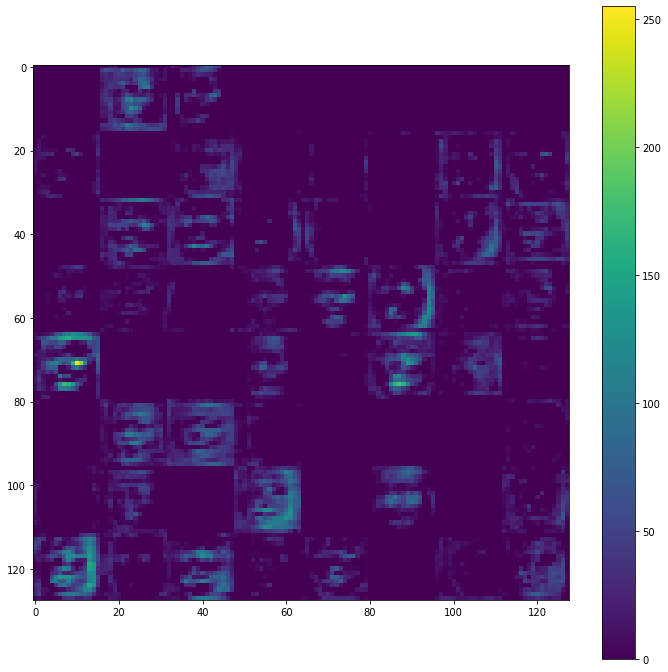

In [235]:
plt.figure(figsize=(12,12))
plt.imshow(activation2)
plt.colorbar()

Same argument for this last example of person without mask.

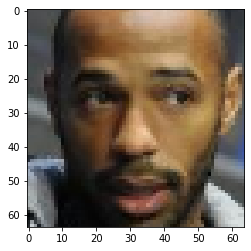

In [238]:
img3, activation3 = generate_activation(47)
plt.imshow(img3)

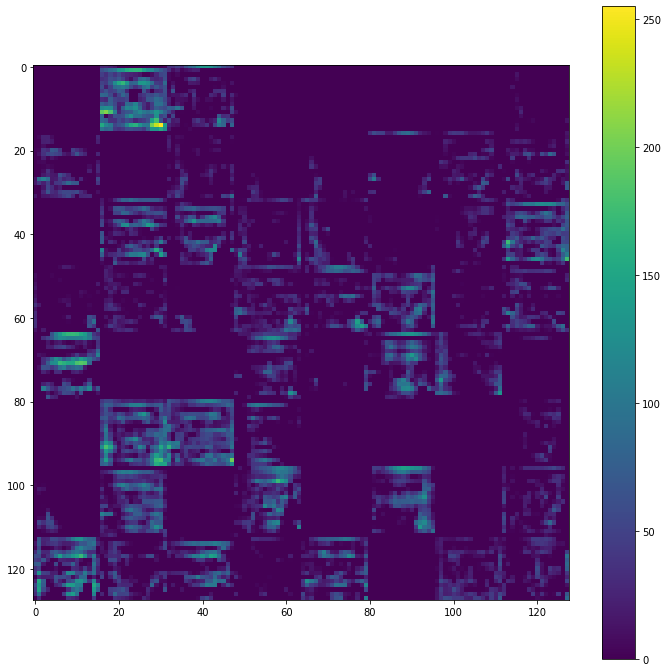

In [239]:
plt.figure(figsize=(12,12))
plt.imshow(activation3)
plt.colorbar()